# HW6: Machine learning

**Due Wednesday April 6, 8pm**

(AY250 2022)

## Galaxy Classification with CNNs

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

You can download it locally:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```
Or access it on the shared drive on `astro.datahub.berkeley.edu` at `shared/HW_6/galaxies10.h5`

First, load the data:

In [11]:
!curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200M  100  200M    0     0  21.7M      0  0:00:09  0:00:09 --:--:-- 31.6M


In [12]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


### Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

In [ ]:
# get first instance of each type
first_of_types = []

for i in range(10):
    column = labels[:,i]
    for j,label in enumerate(column):
        if label == 1:
            first_of_types.append(j)
            break

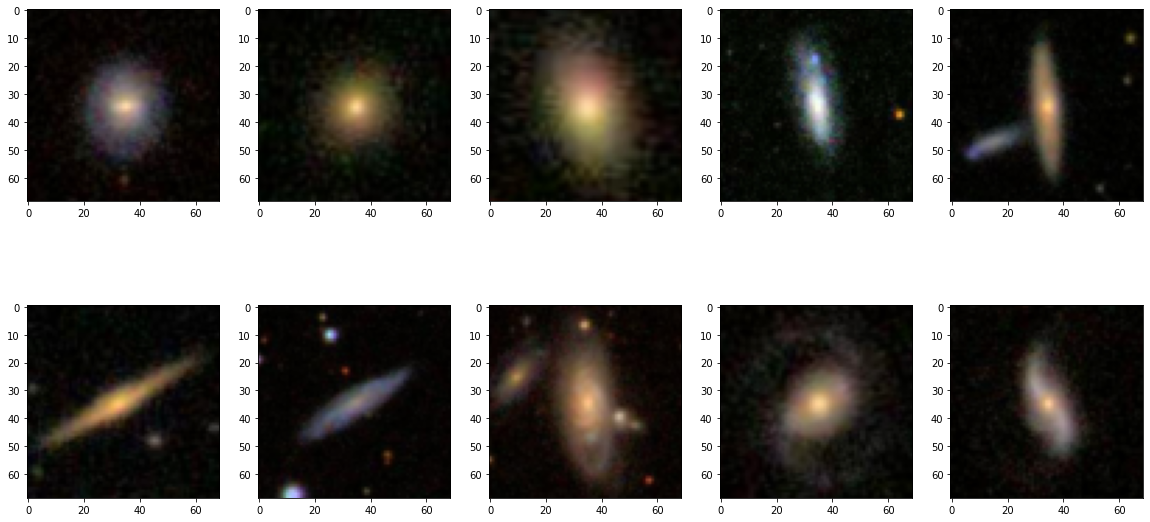

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

fig, ax = plt.subplots(2,5,figsize=(20,10))

imgs = []
for i, index in enumerate(first_of_types):
    x = i // 5
    y = i % 5
    img = images[index]
    pil_img = tf.keras.preprocessing.image.array_to_img(img)
    imgs.append(pil_img)
    ax[x,y].imshow(pil_img)

Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

(array([3461., 6997., 6292.,  349., 1534.,   17.,  589., 1121.,  906.,
         519.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

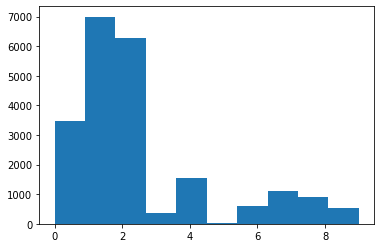

In [ ]:
# get the type of each galaxy as an integer between 0 and 9
labels_n = []
for i,galaxy in enumerate(labels):
    label = np.nonzero(labels[i])[0][0].astype(int)
    labels_n.append(label)

plt.hist(labels_n)

We see that the different types of galaxies are not evenly distributed, in contrast with the MNIST dataset.

### Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

In [ ]:
import datetime, os
import numpy as np
import warnings

#from IPython.external import mathjax

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization
)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
# Print keras version
print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.8.0


In [13]:
from sklearn.utils import shuffle
np.random.seed(2022) # sklearn uses the numpy random state
labels_shuffled, images_shuffled = shuffle(labels, images)

In [14]:
train_ratio, val_ratio = 0.8, 0.9 # cumulative, meaning 80% test, 10% val, 10% test
n = len(labels)
train_num, val_num = int(train_ratio*n), int(val_ratio*n)

labels_train, images_train = labels_shuffled[:train_num], images_shuffled[:train_num]
labels_val, images_val = labels_shuffled[train_num:val_num], images_shuffled[train_num:val_num]
labels_test, images_test = labels_shuffled[val_num:], images_shuffled[val_num:]

(array([2780., 5632., 4993.,  269., 1233.,   14.,  476.,  896.,  718.,
         417.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

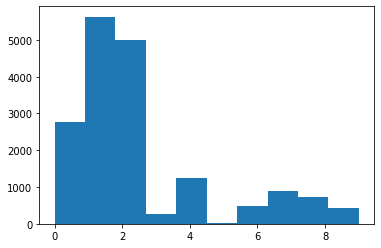

In [15]:
# check the distribution of train, val, test
labels_n_train = []
for i,galaxy in enumerate(labels_train):
    label = np.nonzero(labels_train[i])[0][0].astype(int)
    labels_n_train.append(label)

plt.hist(labels_n_train)

(array([346., 697., 585.,  37., 174.,   2.,  53., 128., 104.,  52.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

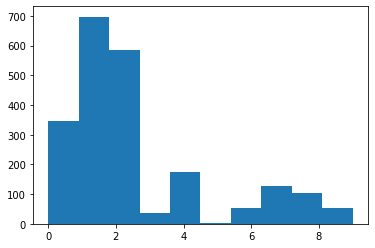

In [ ]:
labels_n_val = []
for i,galaxy in enumerate(labels_val):
    label = np.nonzero(labels_val[i])[0][0].astype(int)
    labels_n_val.append(label)

plt.hist(labels_n_val)

(array([335., 668., 714.,  43., 127.,   1.,  60.,  97.,  84.,  50.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

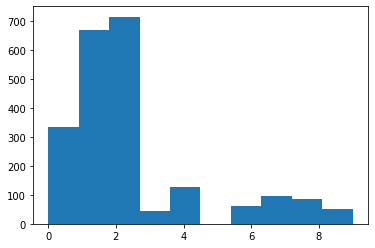

In [ ]:
labels_n_test = []
for i,galaxy in enumerate(labels_test):
    label = np.nonzero(labels_test[i])[0][0].astype(int)
    labels_n_test.append(label)

plt.hist(labels_n_test)

In [ ]:
# add with tf.device('/gpu:0'): if on GPU
K.clear_session()

with tf.device('/gpu:0'):

  input_shape = (69, 69, 3)
  n_classes = 10
  batch_size = 128

  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))

  model.add(Dense(32, activation='relu'))


  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 67, 67, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 67, 67, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 31, 31, 64)        0

### Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

In [ ]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=images_train, 
          y=labels_train, 
          epochs=20,
          batch_size=batch_size,
          validation_data=(images_val, labels_val), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/ay250_nn_2022-04-06T03:20.h5
Epoch 1/20
137/137 [==============================] - ETA: 0s - loss: 1.3510 - accuracy: 0.4549
Epoch 1: val_accuracy improved from -inf to 0.41139, saving model to nn_results/ay250_nn_2022-04-06T03:20.h5
137/137 [==============================] - 8s 50ms/step - loss: 1.3510 - accuracy: 0.4549 - val_loss: 1.7987 - val_accuracy: 0.4114 - lr: 0.0010
Epoch 2/20
137/137 [==============================] - ETA: 0s - loss: 0.9476 - accuracy: 0.6410
Epoch 2: val_accuracy improved from 0.41139 to 0.59871, saving model to nn_results/ay250_nn_2022-04-06T03:20.h5
137/137 [==============================] - 7s 47ms/step - loss: 0.9476 - accuracy: 0.6410 - val_loss: 1.3722 - val_accuracy: 0.5987 - lr: 0.0010
Epoch 3/20
136/137 [============================>.] - ETA: 0s - loss: 0.7282 - accuracy: 0.7378
Epoch 3: val_accuracy improved from 0.59871 to 0.72452, saving model to nn_results/ay250_nn_2022-04-06T03:20.h5
137/137 [===========================

### Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

In [ ]:
model.evaluate(x=images_test, y=labels_test)

69/69 [==============================] - 1s 9ms/step - loss: 0.6198 - accuracy: 0.7843


[0.6197838187217712, 0.7843047380447388]

In [ ]:
predictions = model.predict(images_test)
predictions_n = [np.argmax(cat) for cat in predictions]
labels_test_n = [np.argmax(cat) for cat in labels_test]
conf_mat = tf.math.confusion_matrix(labels_test_n, predictions_n)

In [ ]:
conf_mat

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[199,  30,  37,   0,   3,   0,   0,  19,  27,  20],
       [ 41, 588,  33,   0,   0,   0,   0,   6,   0,   0],
       [ 59,  20, 621,   4,   5,   0,   0,   3,   1,   1],
       [  1,   0,   1,  25,   9,   0,   7,   0,   0,   0],
       [ 11,   0,   4,   3, 102,   1,   3,   0,   0,   3],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  2,   0,   0,   2,   9,   0,  45,   0,   0,   2],
       [ 22,   2,   2,   0,   0,   0,   0,  54,  14,   3],
       [ 23,   0,   0,   0,   0,   0,   0,   7,  47,   7],
       [ 14,   0,   1,   0,   0,   0,   0,   1,   6,  28]], dtype=int32)>

It looks like the model is quite confused with images in categories 8 and 9, classifying less than half of them correctly. Specifically, it looks like the model is confusing these categories with category 0, which kind of makes sense visually. At the same time, the model also struggles to classify galaxies of type 0 correctly, and seems to be all over the place.

### Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(images_train)

seed = 42
batch_size = 128

image_generator = image_datagen.flow(
    images_train, labels_train,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

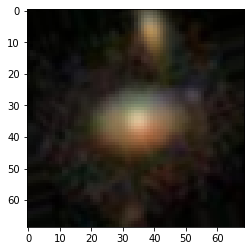

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
rez = image_generator.next()
plt.imshow(rez[0][5])

In [ ]:
rez[0].shape

(128, 69, 69, 3)

In [ ]:
K.clear_session()

with tf.device('/gpu:0'):

  input_shape = (69, 69, 3)
  n_classes = 10
  batch_size = 128

  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))

  model.add(Dense(32, activation='relu'))


  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
  # define path to save model
  model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
  print(f"Training ... {model_path}")

  logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                                patience=2, min_lr=1e-6, verbose=1, cooldown=0)

  csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                              patience=3, \
                                              verbose=1, mode='auto')

  model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
          monitor='val_accuracy', 
          save_best_only=True, 
          mode='max',
          verbose=1)

  model.fit(image_generator,
            epochs=20,
            batch_size=batch_size,
            validation_data=(images_val, labels_val), 
            callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/ay250_nn_2022-04-06T03:24.h5
Epoch 1/20
137/137 [==============================] - ETA: 0s - loss: 1.4199 - accuracy: 0.4409
Epoch 1: val_accuracy improved from -inf to 0.34940, saving model to nn_results/ay250_nn_2022-04-06T03:24.h5
137/137 [==============================] - 33s 237ms/step - loss: 1.4199 - accuracy: 0.4409 - val_loss: 1.9262 - val_accuracy: 0.3494 - lr: 0.0010
Epoch 2/20
137/137 [==============================] - ETA: 0s - loss: 1.0607 - accuracy: 0.5845
Epoch 2: val_accuracy improved from 0.34940 to 0.60927, saving model to nn_results/ay250_nn_2022-04-06T03:24.h5
137/137 [==============================] - 33s 241ms/step - loss: 1.0607 - accuracy: 0.5845 - val_loss: 1.5457 - val_accuracy: 0.6093 - lr: 0.0010
Epoch 3/20
137/137 [==============================] - ETA: 0s - loss: 0.8860 - accuracy: 0.6651
Epoch 3: val_accuracy improved from 0.60927 to 0.61662, saving model to nn_results/ay250_nn_2022-04-06T03:24.h5
137/137 [=======================

In [ ]:
model.evaluate(x=images_test, y=labels_test)

69/69 [==============================] - 1s 8ms/step - loss: 0.5245 - accuracy: 0.8045


[0.5244588255882263, 0.804497480392456]

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

In [ ]:
K.clear_session()

with tf.device('/gpu:0'):

  input_shape = (69, 69, 3)
  n_classes = 10
  batch_size = 128

  model = Sequential()

  model.add(Conv2D(16, (3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.1))

  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(Activation('tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.1))

  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation('tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))

  model.add(Dropout(rate=0.05))

  model.add(Dense(32, activation='tanh'))

  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
  # define path to save model
  model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
  print(f"Training ... {model_path}")

  logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                                patience=2, min_lr=1e-6, verbose=1, cooldown=0)

  csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                              patience=3, \
                                              verbose=1, mode='auto')

  model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
          monitor='val_accuracy', 
          save_best_only=True, 
          mode='max',
          verbose=1)

Training ... nn_results/ay250_nn_2022-04-06T04:15.h5


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 67, 67, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 67, 67, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 33, 33, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 32)        4

In [ ]:
model.fit(image_generator,
            epochs=30,
            batch_size=batch_size,
            validation_data=(images_val, labels_val), 
            callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Epoch 1/30
137/137 [==============================] - ETA: 0s - loss: 1.3809 - accuracy: 0.4396
Epoch 1: val_accuracy improved from -inf to 0.38200, saving model to nn_results/ay250_nn_2022-04-06T04:15.h5
137/137 [==============================] - 28s 200ms/step - loss: 1.3809 - accuracy: 0.4396 - val_loss: 1.6965 - val_accuracy: 0.3820 - lr: 0.0010
Epoch 2/30
137/137 [==============================] - ETA: 0s - loss: 1.0285 - accuracy: 0.6021
Epoch 2: val_accuracy improved from 0.38200 to 0.59688, saving model to nn_results/ay250_nn_2022-04-06T04:15.h5
137/137 [==============================] - 28s 206ms/step - loss: 1.0285 - accuracy: 0.6021 - val_loss: 1.1391 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 3/30
137/137 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.6646
Epoch 3: val_accuracy improved from 0.59688 to 0.61249, saving model to nn_results/ay250_nn_2022-04-06T04:15.h5
137/137 [==============================] - 27s 200ms/step - loss: 0.8843 - accuracy: 

In [ ]:
 model.evaluate(x=images_test, y=labels_test)

69/69 [==============================] - 1s 8ms/step - loss: 0.5418 - accuracy: 0.8031


[0.541789710521698, 0.8031206727027893]

In [ ]:
predictions = model.predict(images_test)
predictions_n = [np.argmax(cat) for cat in predictions]
labels_test_n = [np.argmax(cat) for cat in labels_test]
tf.math.confusion_matrix(labels_test_n, predictions_n)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[186,  52,  50,   7,   1,   0,   0,  14,  12,  13],
       [ 15, 644,   6,   0,   0,   0,   0,   3,   0,   0],
       [ 36,  60, 612,   4,   0,   0,   0,   1,   1,   0],
       [  0,   0,   3,  28,   5,   0,   7,   0,   0,   0],
       [  3,   0,   5,   5, 108,   0,   2,   0,   0,   4],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   9,  10,   0,  41,   0,   0,   0],
       [ 32,   4,   4,   0,   0,   0,   0,  52,   5,   0],
       [ 27,   1,   0,   0,   0,   0,   0,   5,  41,  10],
       [  9,   0,   0,   0,   0,   0,   0,   0,   3,  38]], dtype=int32)>

I tried adding dropouts (same as code in lecture notebook). It made the training process longer and appeared to be more robust to overfitting, but did not improve test accuracy. Tried adding more layers, again no major improvement. Tried changing some of the activations to tanh, still no major improvement. 80% accuracy was the best I could achieve out of everything I tried :/

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [16]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

2.8.0


Make a simple autoencoder

In [138]:
input_shape = (69, 69, 3)
input_img = Input(shape=input_shape)
bottleneck_size = 4

images_train_rescaled = images_train / 255.0
images_val_rescaled = images_val / 255.0
images_test_rescaled = images_test / 255.0

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.ZeroPadding2D(padding=((1,2),(1,2)))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (9, 9, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(648)(bottleneck)
x = Reshape((9, 9, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(x)

# add with tf.device('/gpu:0'): if on GPU
with tf.device('/gpu:0'):
    autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Training ... nn_results/ay250_autoencoder_nn_2022-04-06T23:38.h5


In [139]:
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 69, 69, 3)]       0         
                                                                 
 conv2d_70 (Conv2D)          (None, 69, 69, 16)        448       
                                                                 
 zero_padding2d_17 (ZeroPadd  (None, 72, 72, 16)       0         
 ing2D)                                                          
                                                                 
 batch_normalization_10 (Bat  (None, 72, 72, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 36, 36, 16)       0         
 g2D)                                                            
                                                          

In [140]:
autoencoder_train = autoencoder.fit(images_train_rescaled, images_train_rescaled,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(images_val_rescaled, images_val_rescaled),
                                    callbacks=[tensorboard_callback, model_check])

Epoch 1/10
136/137 [============================>.] - ETA: 0s - loss: 0.0201
Epoch 1: val_loss improved from inf to 0.06180, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T23:38.h5
137/137 [==============================] - 11s 69ms/step - loss: 0.0201 - val_loss: 0.0618
Epoch 2/10
136/137 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 2: val_loss improved from 0.06180 to 0.02383, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T23:38.h5
137/137 [==============================] - 8s 61ms/step - loss: 0.0037 - val_loss: 0.0238
Epoch 3/10
136/137 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 3: val_loss improved from 0.02383 to 0.00692, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T23:38.h5
137/137 [==============================] - 8s 61ms/step - loss: 0.0029 - val_loss: 0.0069
Epoch 4/10
136/137 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 4: val_loss improved from 0.00692 to 0.00300, saving model 

In [141]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

Using nn_results/ay250_autoencoder_nn_2022-04-06T23:38.h5


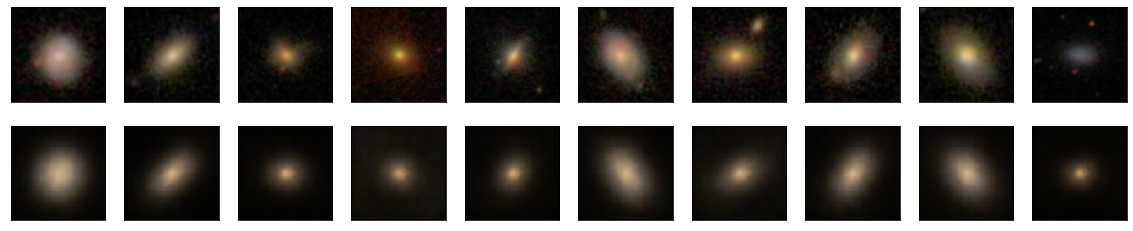

In [142]:
decoded_imgs = autoencoder.predict(images_test_rescaled)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images_test[i].astype(int))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

In [143]:
# bottleneck model
bottleneck_output = autoencoder.get_layer('bottleneck').output
model_bottleneck = Model(inputs = autoencoder.input, outputs = bottleneck_output)

bottleneck_train = model_bottleneck.predict(images_train_rescaled)
bottleneck_test = model_bottleneck.predict(images_test_rescaled)

In [144]:
# need to convert labels from categorical back to numerical
n_train = len(labels_train)
n_test = len(labels_test)

labels_train_n = [np.nonzero(labels_train[i])[0][0].astype(int) for i in range(n_train)]
labels_test_n = [np.nonzero(labels_test[i])[0][0].astype(int) for i in range(n_test)]

In [145]:
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier object
classifier = RandomForestClassifier(n_estimators=100)

# fit the classification model on training set
classifier.fit(bottleneck_train, labels_train_n)

# make predictions for testing set
pred_rf = classifier.predict(bottleneck_test)

In [146]:
# check first ten predictions
print("True Class / Predicted class")
print(np.vstack((labels_test_n[:10],pred_rf[:10])))

True Class / Predicted class
[[1 2 0 1 4 2 2 0 2 2]
 [1 2 0 1 1 2 0 2 2 1]]


In [147]:
# compute accuracy across test set
correct_count = 0

for i in range(n_test):
    if labels_test_n[i] == pred_rf[i]:
        correct_count += 1

accuracy = correct_count/n_test
print(f"Accuracy: {accuracy}")

Accuracy: 0.6140431390546122


### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?

Here is what I found:

Bottleneck size | Accuracy

64 | 0.6439

32 | 0.6696

16 | 0.6654

4 | 0.6140


It looks like intermediate bottleneck sizes (32 and 16) are slightly better than the rest, but the difference is not significant. Overall, this method appears significantly worse than the approach of directly training a CNN.